In [1]:
from montlake.optimization.gradientgrouplasso import get_sr_lambda_parallel
from montlake.simulations.swissroll import get_swiss_roll_data, get_swiss_roll_gradients_noy_norotate, get_swiss_roll_gradients_noy
from montlake.geometry.geometry import get_geom, get_wlpca_tangent_sel, get_rm_tangent_sel
from montlake.utils.replicates import Replicate
from montlake.statistics.normalization import normalize_L212
from montlake.gradients.estimate import get_grads_pullback
from megaman.embedding import LTSA
from megaman.embedding import Isomap
from megaman.embedding import SpectralEmbedding
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
from montlake.plotting.plotting import plot_reg_path_ax_lambdasearch_customcolors_names

In [2]:
data, rotator, ts, ys = get_swiss_roll_data(n = 10000, theta =np.pi / 4,xvar = 0.00, rotate = False, b = 49)
radius = 1.88
n_neighbors = 100
geom = get_geom(data, radius, n_neighbors)  

/Users/samsonkoelle/miniconda3/envs/manifold_env_april/lib/python3.5/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [3]:
n_components = 2
b = 49
d = 2
spectral_embedding = SpectralEmbedding(n_components=n_components,eigen_solver='arpack',geom=geom)
embed_spectral = spectral_embedding.fit_transform(data)


/Users/samsonkoelle/miniconda3/envs/manifold_env_april/lib/python3.5/site-packages/sklearn/utils/validation.py:457: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)


In [4]:
nreps = 1
nsel = 100 
replicates = {}
embedding = embed_spectral
for r in range(nreps):
    #print(i)
    replicates[r] = Replicate(nsel = nsel, n = 10000)
    replicates[r].tangent_bases_M = get_wlpca_tangent_sel(data, geom, replicates[r].selected_points, d)
    replicates[r].tangent_bases_phi = get_rm_tangent_sel(embedding, geom, replicates[r].selected_points, d)
    #replicates[r].dg_x = np.asarray([get_swiss_roll_gradients_noy(ts[replicates[r].selected_points[i]], rotator, b) for i in range(nsel)])
    replicates[r].dg_x = np.asarray([get_swiss_roll_gradients_noy_norotate(ts[replicates[r].selected_points[i]], b) for i in range(nsel)])
    replicates[r].dg_x_normalized = normalize_L212(replicates[r].dg_x)
    replicates[r].dg_M = np.einsum('i b p, i b d -> i d p', replicates[r].dg_x_normalized, replicates[r].tangent_bases_M)
    replicates[r].dphispectral_M = get_grads_pullback(data,  embedding, geom, replicates[r].tangent_bases_M, replicates[r].tangent_bases_phi, replicates[r].selected_points)
    replicates[r].dphispectral_M_normalized = normalize_L212(replicates[r].dphispectral_M)
    

In [5]:
from montlake.optimization.gradientgrouplasso import get_sr_lambda_parallel
gl_itermax = 500
r = 0
max_search = 30
reg_l2 = 0.
tol = 1e-14
learning_rate = 100
replicates[r].results = get_sr_lambda_parallel(replicates[r].dphispectral_M_normalized , replicates[r].dg_M, gl_itermax,reg_l2, max_search, d, tol,learning_rate)


initializing lambda search
converged 10.017437406233062
0 5.008718703116531 probe
converged 5.008718703116531
1 2.5043593515582656 probe
converged 2.5043593515582656
2 1.2521796757791328 probe
converged 1.2521796757791328
3 0.6260898378895664 probe
converged 0.6260898378895664
4 0.3130449189447832 probe
converged 0.3130449189447832
5 0.1565224594723916 probe
6 0.2347836892085874 probe
converged 0.2347836892085874
7 0.1956530743404895 probe
converged 0.1956530743404895
8 0.17608776690644057 probe
converged 0.17608776690644057
9 0.1663051131894161 probe
converged 0.1663051131894161
10 0.16141378633090386 probe
converged 0.16141378633090386
11 0.15896812290164775 probe
converged 0.15896812290164775
12 0.1577452911870197 probe
converged 0.1577452911870197
13 0.15713387532970563 probe
converged 0.15713387532970563
14 0.1568281674010486 probe
converged 0.1568281674010486
15 0.1566753134367201 probe
converged 0.1566753134367201
16 0.15659888645455583 probe
converged 0.15659888645455583
17 0.1

In [6]:
rep = replicates[r]

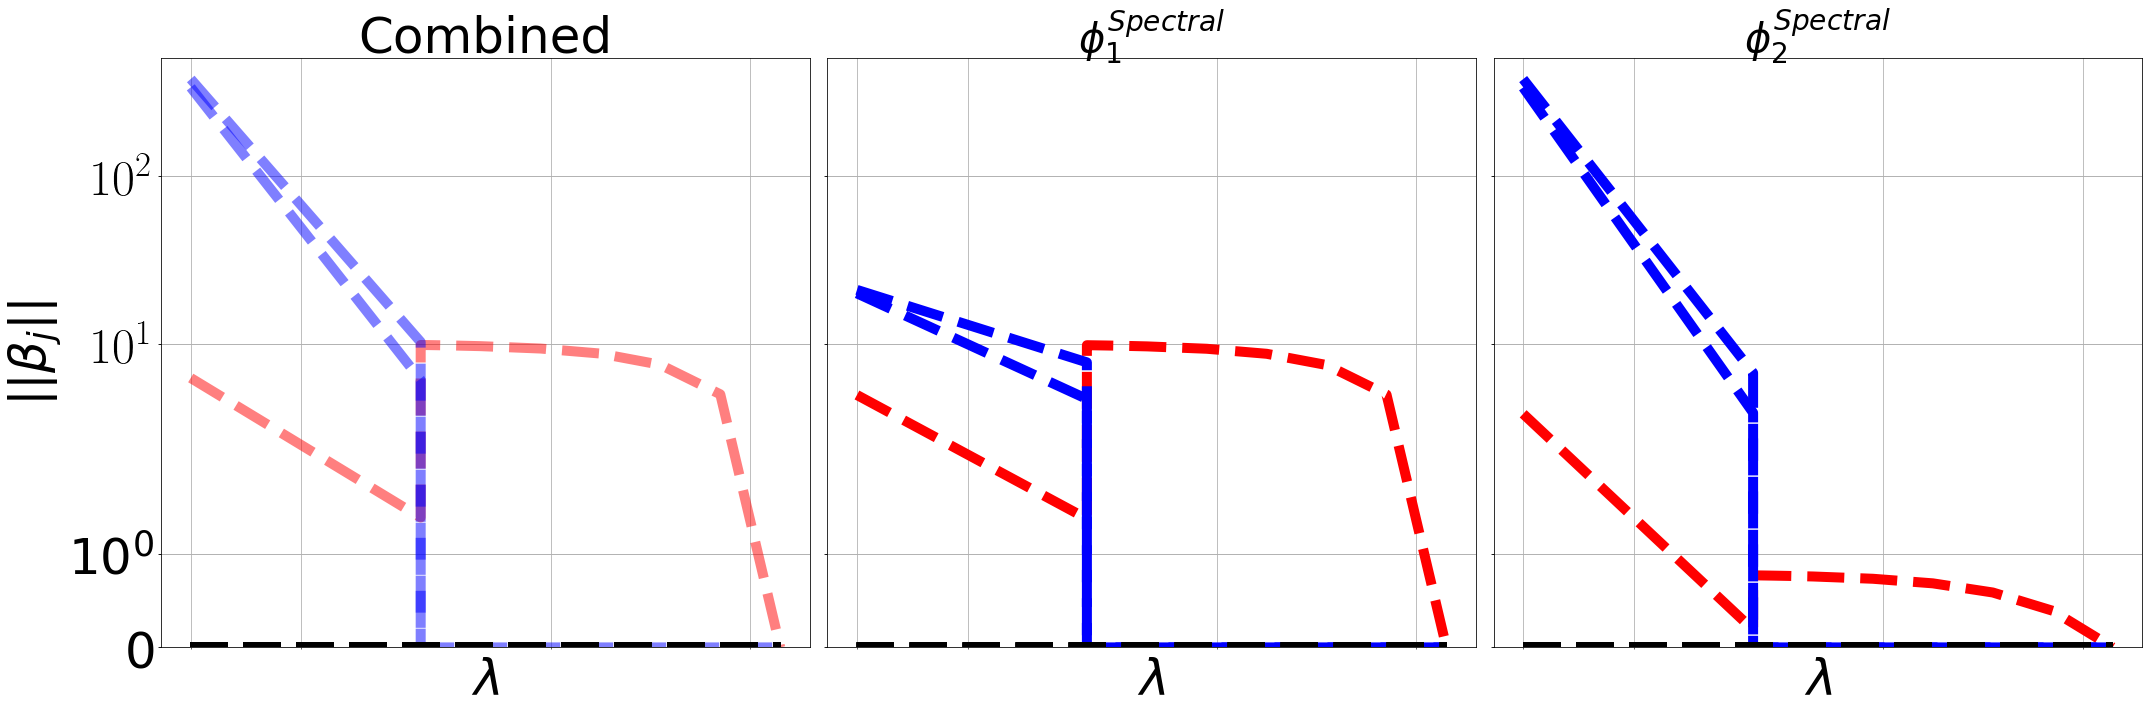

In [7]:

m = 2
colors = np.hstack([np.repeat('red',1), np.repeat('blue',2),np.repeat('black',48)])
replicates[r].get_ordered_axes()

%matplotlib inline
matplotlib.rc('font', family='sans-serif')
fig, axes_all = plt.subplots(1,3, figsize=(30,10) )
names = [r'$\phi_1^{Spectral}$', r'$\phi_2^{Spectral}$']
plot_reg_path_ax_lambdasearch_customcolors_names(axes_all, replicates[0].cs_reorder, replicates[0].xaxis_reorder * np.sqrt(m * nsel), fig,colors, names)
#axes_all[2].legend('off')
plt.tight_layout()
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_internal_mflasso', bbox_inches = "tight")

In [8]:
data, rotator, ts, ys = get_swiss_roll_data(n = 10000, theta =np.pi / 4,xvar = 0.001, rotate = False, b = 49)
radius = 1.88
n_neighbors = 100
geom = get_geom(data, radius, n_neighbors)  

n_components = 2
b = 49
d = 2
spectral_embedding = SpectralEmbedding(n_components=n_components,eigen_solver='arpack',geom=geom)
embed_spectral = spectral_embedding.fit_transform(data)

nreps = 1
nsel = 100 
replicates = {}
embedding = embed_spectral
for r in range(nreps):
    #print(i)
    replicates[r] = Replicate(nsel = nsel, n = 10000)
    replicates[r].tangent_bases_M = get_wlpca_tangent_sel(data, geom, replicates[r].selected_points, d)
    replicates[r].tangent_bases_phi = get_rm_tangent_sel(embedding, geom, replicates[r].selected_points, d)
    #replicates[r].dg_x = np.asarray([get_swiss_roll_gradients_noy(ts[replicates[r].selected_points[i]], rotator, b) for i in range(nsel)])
    replicates[r].dg_x = np.asarray([get_swiss_roll_gradients_noy_norotate(ts[replicates[r].selected_points[i]], b) for i in range(nsel)])
    replicates[r].dg_x_normalized = normalize_L212(replicates[r].dg_x)
    replicates[r].dg_M = np.einsum('i b p, i b d -> i d p', replicates[r].dg_x_normalized, replicates[r].tangent_bases_M)
    replicates[r].dphispectral_M = get_grads_pullback(data,  embedding, geom, replicates[r].tangent_bases_M, replicates[r].tangent_bases_phi, replicates[r].selected_points)
    replicates[r].dphispectral_M_normalized = normalize_L212(replicates[r].dphispectral_M)
    
#from montlake.optimization.gradientgrouplasso import get_sr_lambda_parallel
gl_itermax = 500
r = 0
max_search = 30
reg_l2 = 0.
tol = 1e-14
learning_rate = 100
replicates[r].results = get_sr_lambda_parallel(replicates[r].dphispectral_M_normalized , replicates[r].dg_M, gl_itermax,reg_l2, max_search, d, tol,learning_rate)


/Users/samsonkoelle/miniconda3/envs/manifold_env_april/lib/python3.5/site-packages/sklearn/utils/validation.py:457: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)


initializing lambda search
converged 9.998604449899322
0 4.999302224949661 probe
converged 4.999302224949661
1 2.4996511124748304 probe
converged 2.4996511124748304
2 1.2498255562374152 probe
converged 1.2498255562374152
3 0.6249127781187076 probe
converged 0.6249127781187076
4 0.3124563890593538 probe
converged 0.3124563890593538
5 0.1562281945296769 probe
Selected functions [0 1]


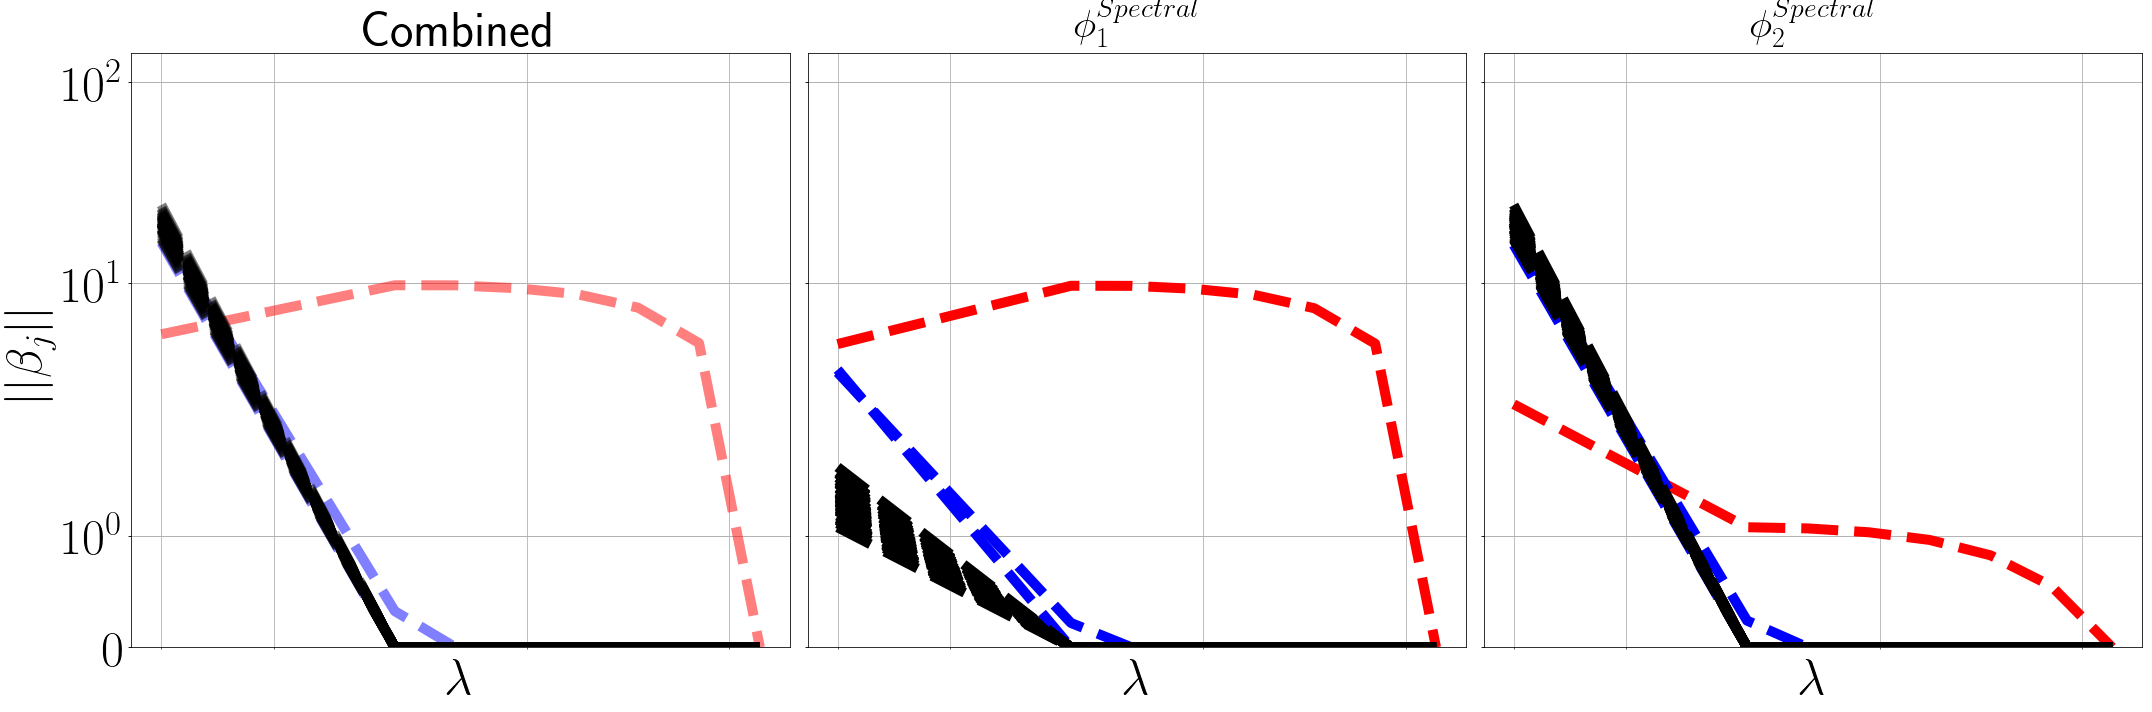

In [9]:
m = 2
colors = np.hstack([np.repeat('red',1), np.repeat('blue',2),np.repeat('black',48)])
replicates[r].get_ordered_axes()

%matplotlib inline
matplotlib.rc('font', family='sans-serif')
fig, axes_all = plt.subplots(1,3, figsize=(30,10) )
names = [r'$\phi_1^{Spectral}$', r'$\phi_2^{Spectral}$']
plot_reg_path_ax_lambdasearch_customcolors_names(axes_all, replicates[0].cs_reorder, replicates[0].xaxis_reorder * np.sqrt(m * nsel), fig,colors, names)
#axes_all[2].legend('off')
plt.tight_layout()
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_internal_mflasso', bbox_inches = "tight")

In [10]:
data, rotator, ts, ys = get_swiss_roll_data(n = 10000, theta =np.pi / 4,xvar = 0.00, rotate = True, b = 49)
radius = 1.88
n_neighbors = 100
geom = get_geom(data, radius, n_neighbors)  

n_components = 2
b = 49
d = 2
spectral_embedding = SpectralEmbedding(n_components=n_components,eigen_solver='arpack',geom=geom)
embed_spectral = spectral_embedding.fit_transform(data)

nreps = 1
nsel = 100 
replicates = {}
embedding = embed_spectral
for r in range(nreps):
    #print(i)
    replicates[r] = Replicate(nsel = nsel, n = 10000)
    replicates[r].tangent_bases_M = get_wlpca_tangent_sel(data, geom, replicates[r].selected_points, d)
    replicates[r].tangent_bases_phi = get_rm_tangent_sel(embedding, geom, replicates[r].selected_points, d)
    #replicates[r].dg_x = np.asarray([get_swiss_roll_gradients_noy(ts[replicates[r].selected_points[i]], rotator, b) for i in range(nsel)])
    replicates[r].dg_x = np.asarray([get_swiss_roll_gradients_noy(ts[replicates[r].selected_points[i]], rotator,b) for i in range(nsel)])
    replicates[r].dg_x_normalized = normalize_L212(replicates[r].dg_x)
    replicates[r].dg_M = np.einsum('i b p, i b d -> i d p', replicates[r].dg_x_normalized, replicates[r].tangent_bases_M)
    replicates[r].dphispectral_M = get_grads_pullback(data,  embedding, geom, replicates[r].tangent_bases_M, replicates[r].tangent_bases_phi, replicates[r].selected_points)
    replicates[r].dphispectral_M_normalized = normalize_L212(replicates[r].dphispectral_M)
    
#from montlake.optimization.gradientgrouplasso import get_sr_lambda_parallel
gl_itermax = 500
r = 0
max_search = 30
reg_l2 = 0.
tol = 1e-14
learning_rate = 100
replicates[r].results = get_sr_lambda_parallel(replicates[r].dphispectral_M_normalized , replicates[r].dg_M, gl_itermax,reg_l2, max_search, d, tol,learning_rate)


/Users/samsonkoelle/miniconda3/envs/manifold_env_april/lib/python3.5/site-packages/sklearn/utils/validation.py:457: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)


initializing lambda search
converged 10.00055296734515
0 5.000276483672575 probe
converged 5.000276483672575
1 2.5001382418362876 probe
converged 2.5001382418362876
Selected functions [ 0 22]


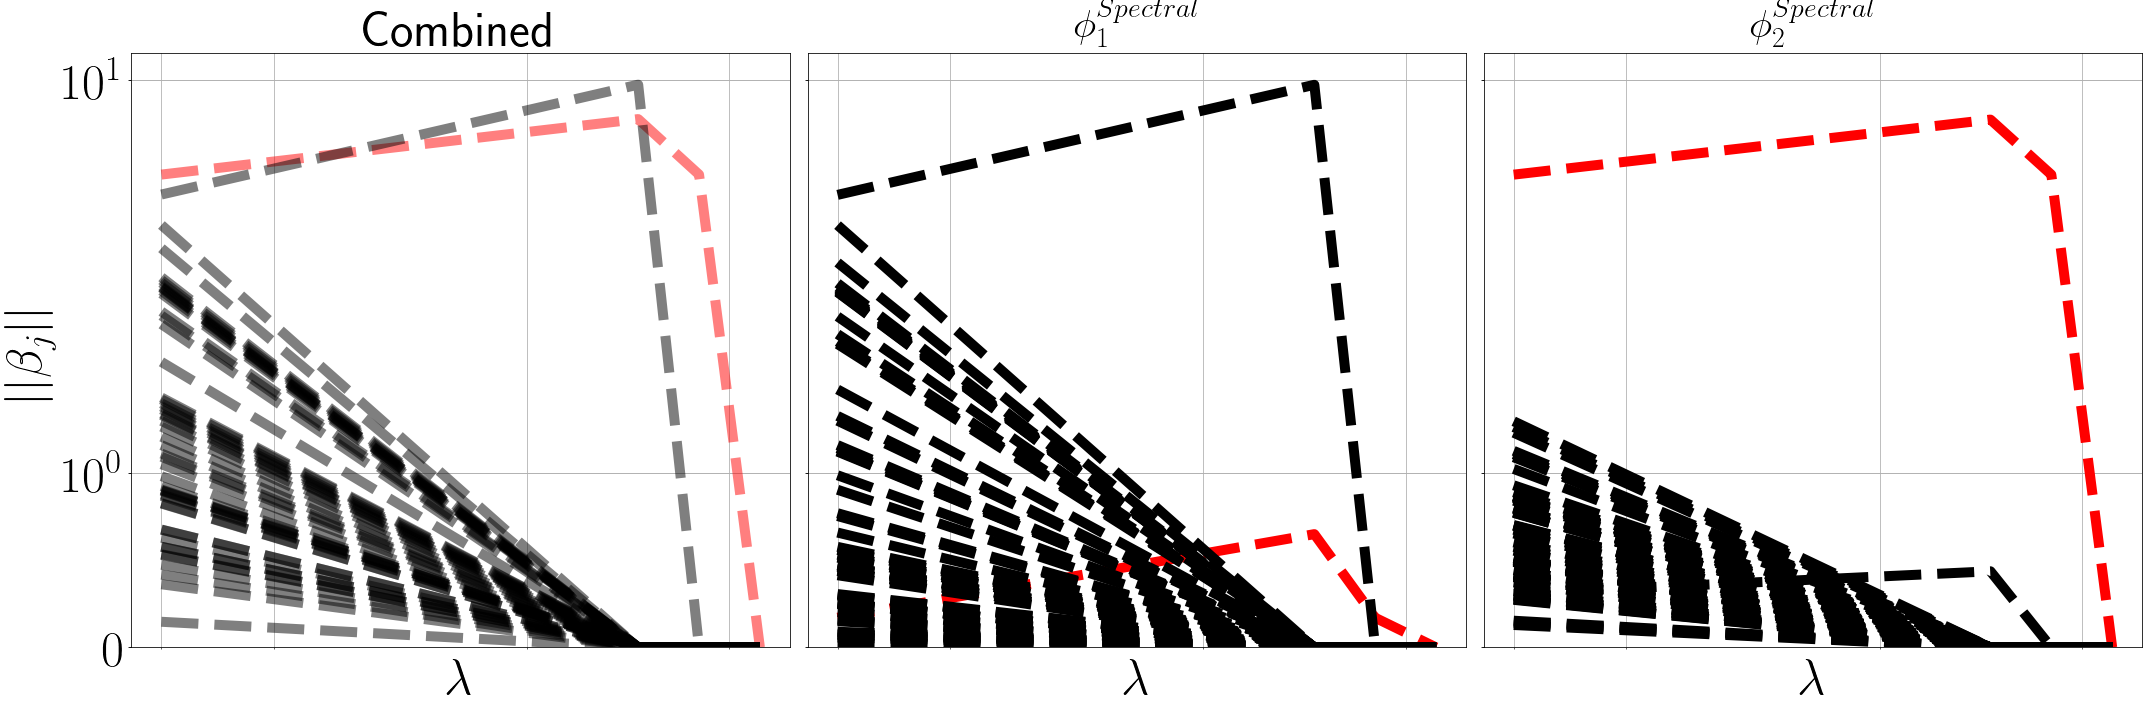

In [8]:
m = 2
import matplotlib
colors = np.hstack([np.repeat('red',1),np.repeat('black',49)])
replicates[r].get_ordered_axes()

%matplotlib inline
matplotlib.rc('font', family='sans-serif')
fig, axes_all = plt.subplots(1,3, figsize=(30,10) )
names = [r'$\phi_1^{Spectral}$', r'$\phi_2^{Spectral}$']
plot_reg_path_ax_lambdasearch_customcolors_names(axes_all, replicates[0].cs_reorder, replicates[0].xaxis_reorder * np.sqrt(m * nsel), fig,colors, names)
#axes_all[2].legend('off')
plt.tight_layout()
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_internal_mflasso', bbox_inches = "tight")